# SIR model with constant transmission rate

Solving the SIR model with constant transmission rate $\beta$ and recovery rate $\delta$.

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

In [200]:
from dotenv import load_dotenv
import torch
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

load_dotenv()

print("PyTorch version:", torch.__version__)
print("DeepXDE version:", dde.__version__)

PyTorch version: 2.5.1
DeepXDE version: 1.12.2


## Generate synthetic data

Define the SIR model parameters.

In [201]:
# Population parameters (using Italy as reference)
N = 56e6            # Total population
delta = 1 / 5       # Recovery rate (1 / mean infectious period)
r0 = 3.0            # Basic reproduction number

beta = delta * r0   # Transmission rate
t0, tf = 0, 90      # Time span in days

# Scaling constants
C = 1e5
C1 = tf * C / N
C2 = tf * delta

Generate synthetic data

In [202]:
# Define the SIR model differential equations
def SIR(x, t, delta, beta, N):
	S, I, R = x
	lambda_val = beta * I / N
	dSdt = -lambda_val * S
	dIdt = lambda_val * S - delta * I
	dRdt = delta * I
	return [dSdt, dIdt, dRdt]

# Initial conditions
S0 = N - 1
I0 = 1
R0 = 0
x0 = [S0, I0, R0]

# Time points
t_data = np.linspace(t0, tf, 90)  # Daily data over 90 days

# Solve the SIR model ODEs to generate synthetic data
x = odeint(SIR, x0, t_data, args=(delta, beta, N))
S_data = x[:, 0]
I_data = x[:, 1]
R_data = x[:, 2]

# Generate noisy observations of I(t)
I_obs = np.random.poisson(I_data)

# Scale the data
t_data_sc = t_data / tf
I_obs_sc = I_obs / C
S_data_sc = S_data / C
I_data_sc = I_data / C
R_data_sc = R_data / C

Plot the synthetic data

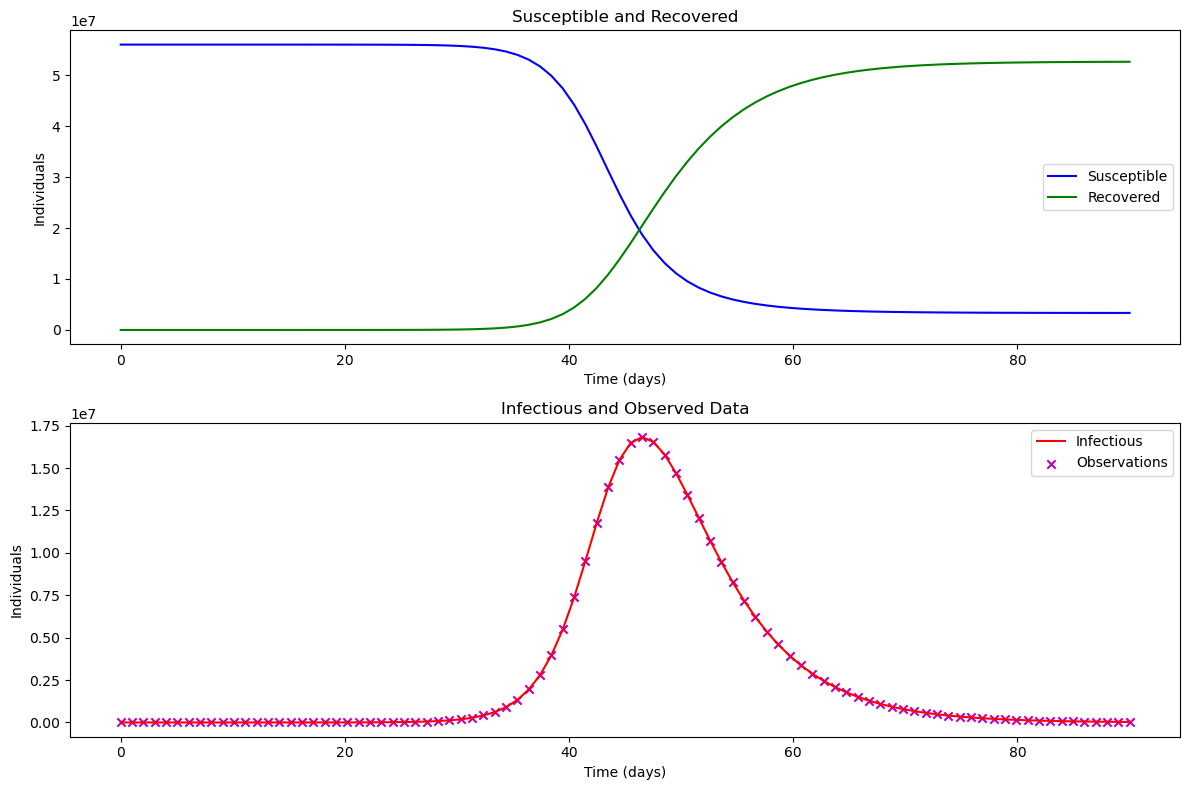

In [203]:
plt.figure(figsize=(12, 8))

# Plot Susceptible and Recovered populations
plt.subplot(2, 1, 1)
plt.plot(t_data, S_data, 'b', label='Susceptible')
plt.plot(t_data, R_data, 'g', label='Recovered')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Individuals')
plt.title('Susceptible and Recovered')

# Plot Infectious population and observations
plt.subplot(2, 1, 2)
plt.plot(t_data, I_data, 'r', label='Infectious')
plt.scatter(t_data, I_obs, c='m', marker='x', label='Observations')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Individuals')
plt.title('Infectious and Observed Data')
plt.tight_layout()
plt.show()

## Modelling the Network


In [204]:
import deepxde as dde

# note: determinism in general comes at the expense of lower performance
dde.config.set_random_seed(1234)

Define the time domain geometry, scaled to the range [0, 1].

In [205]:
geom = dde.geometry.TimeDomain(t0 / tf, tf / tf)

Define the beta parameter as a trainable variable with initial guess.

In [206]:
beta_var = dde.Variable(0.5)

Define the ODE system.

In [207]:
def ode_system(t, y):
	# print("[INFO] y:", y.shape)
	S = y[:, 0:1]
	I = y[:, 1:2]
	R = y[:, 2:3]
	dS_t = dde.grad.jacobian(y, t, i=0)
	dI_t = dde.grad.jacobian(y, t, i=1)
	dR_t = dde.grad.jacobian(y, t, i=2)

	# Compute the transmission term
	lambda_val = beta_var * I / N
	# ODE residuals
	res_s = dS_t + lambda_val * S
	res_i = dI_t - (lambda_val * S - delta * I)
	res_r = dR_t - delta * I
	# print("[INFO] return:", torch.cat([res_s, res_i, res_r], dim=1).shape)
	return torch.cat([res_s, res_i, res_r], dim=1)

Define the initial condition.

In [208]:
def boundary_ic(t, on_initial):
	return on_initial and np.isclose(t[0], t0 / tf)

ic_S = dde.icbc.IC(geom, lambda t: (N - 1) / C, boundary_ic, component=0)
ic_I = dde.icbc.IC(geom, lambda t: 1 / C, boundary_ic, component=1)
ic_R = dde.icbc.IC(geom, lambda t: 0.0, boundary_ic, component=2)

Define the boundary condition using the observed $I(t)$ data.

In [209]:
observe_I = dde.icbc.PointSetBC(
	t_data_sc.reshape(-1, 1),  # Scaled time points
	I_obs_sc.reshape(-1, 1),   # Scaled observed I(t)
	component=1  # Index of I(t) in the network output
)

Define the ODE problem with the ICs and BCs.

We use 6000 points inside the domain and 2 points on the boundary (the start and the end of the time domain).

We use the synthetic (and scaled) time domain to define the points where the data is observed.

In [210]:
data = dde.data.PDE(
	geom,
	ode_system,
	[ic_S, ic_I, ic_R, observe_I],
	num_domain=6000,
	num_boundary=2,
	anchors=t_data_sc.reshape(-1, 1),
	num_test=100
)

Define the network.

In [211]:
layer_size = [1] + [50] * 3 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

Define the model, including the beta parameter as an external trainable variable.

In [212]:
model = dde.Model(data, net)

model.compile(
	optimizer="adam",
	lr=0.001,
	external_trainable_variables=[beta_var],
	# metrics=["l2 relative error"]
)

Compiling model...
'compile' took 0.000121 s



Train the model.

In [213]:
loss_history, train_state = model.train(iterations=20000)

Training model...

0         [9.75e-02, 3.14e+05, 1.00e-10, 0.00e+00, 3.17e+03]    [9.75e-02, 3.14e+05, 1.00e-10, 0.00e+00, 3.17e+03]    []  
1000      [5.43e+00, 2.46e+05, 2.04e+02, 6.58e-11, 2.56e+03]    [5.43e+00, 2.46e+05, 2.04e+02, 6.58e-11, 2.56e+03]    []  
2000      [5.43e+00, 2.01e+05, 2.04e+02, 3.17e-12, 2.56e+03]    [5.43e+00, 2.01e+05, 2.04e+02, 3.17e-12, 2.56e+03]    []  
3000      [5.43e+00, 1.61e+05, 2.04e+02, 1.59e-12, 2.56e+03]    [5.43e+00, 1.61e+05, 2.04e+02, 1.59e-12, 2.56e+03]    []  
4000      [5.43e+00, 1.26e+05, 2.04e+02, 1.09e-14, 2.56e+03]    [5.43e+00, 1.26e+05, 2.04e+02, 1.09e-14, 2.56e+03]    []  
5000      [5.43e+00, 9.61e+04, 2.04e+02, 5.00e-16, 2.56e+03]    [5.43e+00, 9.61e+04, 2.04e+02, 5.00e-16, 2.56e+03]    []  
6000      [5.43e+00, 7.08e+04, 2.04e+02, 5.04e-10, 2.56e+03]    [5.43e+00, 7.08e+04, 2.04e+02, 5.04e-10, 2.56e+03]    []  
7000      [5.43e+00, 4.98e+04, 2.04e+02, 4.77e-08, 2.56e+03]    [5.43e+00, 4.98e+04, 2.04e+02, 4.77e-08, 2.56e+03]    []

Visualize and save the loss history.

Saving loss history to /Users/giacomo/dev/notebooks/dde-playground/sir/loss.dat ...
Saving training data to /Users/giacomo/dev/notebooks/dde-playground/sir/train.dat ...
Saving test data to /Users/giacomo/dev/notebooks/dde-playground/sir/test.dat ...


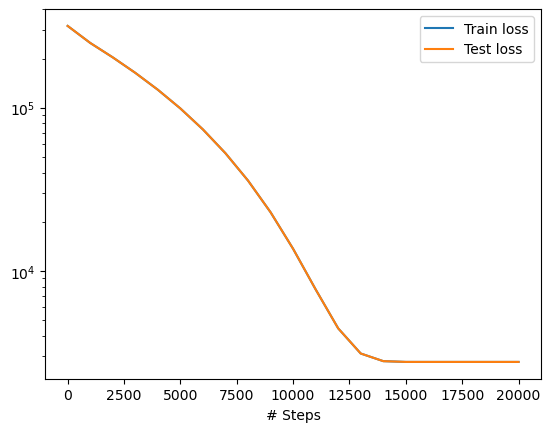

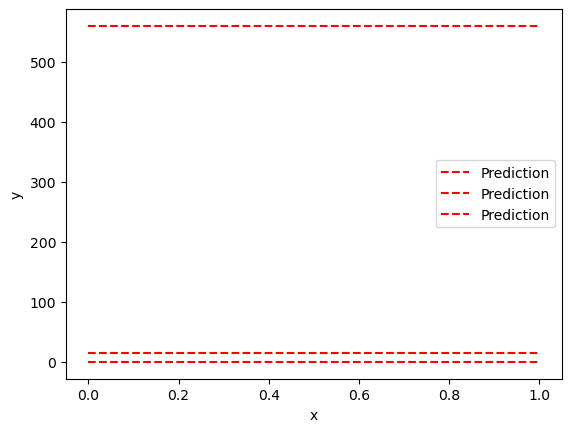

In [214]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)